In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import re
import json  
from pprint import pprint
from bs4 import BeautifulSoup
import urllib.request

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler

RANDOM_SEED = 50

df = pd.read_csv('main_task.csv')

In [2]:
df.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [4]:
# Переименовываем признаки, избавляясь от пробелов в названии.
df.rename(columns={'Cuisine Style': 'Cuisine_Style', 'Price Range': 'Price_Range', 'Number of Reviews':'Number_of_Reviews'}, inplace=True)
df.head(5)

,Restaurant_id,City,Cuisine_Style,Ranking,Rating,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [5]:
# Заполняем отсутствующие значения Price_Range средним ценовым рейтингом.
df['Price_Range'].fillna(value='$$ - $$$', inplace=True)
#После этого переводим строковые значения в числовой рейтинг.
df['Price_Range'] = df['Price_Range'].replace(['$', '$$ - $$$', '$$$$'], [1, 2, 3])

In [6]:
# Удаляем ненужные для модели признаки.
df.drop(['ID_TA',], axis = 1, inplace=True)

In [7]:
# Исправляем название города Oporto - на корректное Porto (как на Tripadvisor).
df['City'] = df['City'].replace('Oporto', 'Porto')

In [8]:
# Т.к. Number of Reviews является важным признаком, вынесем в отдельный признак информацию о наличии пропуска в этих данных.
df['Number_of_Reviews_isNAN'] = pd.isna(df['Number_of_Reviews']).astype('uint8')

In [9]:
# Заполняем отсутствующие значения Number_of_Reviews средним значением для города.
reviews_mean = df.groupby('City')['Number_of_Reviews'].mean()
df['Number_of_Reviews'] = df['Number_of_Reviews'].fillna(df['City'].map(reviews_mean))

<AxesSubplot:>

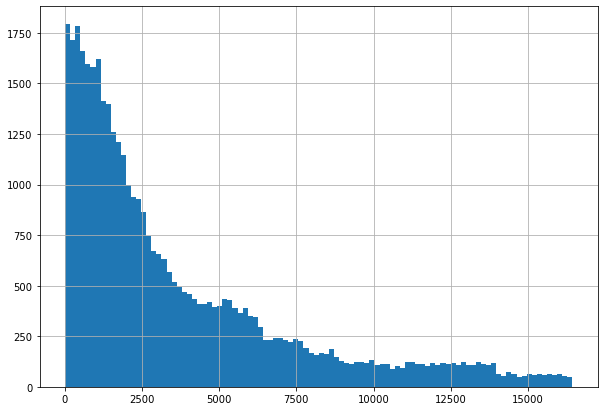

In [10]:
#Посмотрим распределение признака
plt.rcParams['figure.figsize'] = (10,7)
df['Ranking'].hist(bins=100)

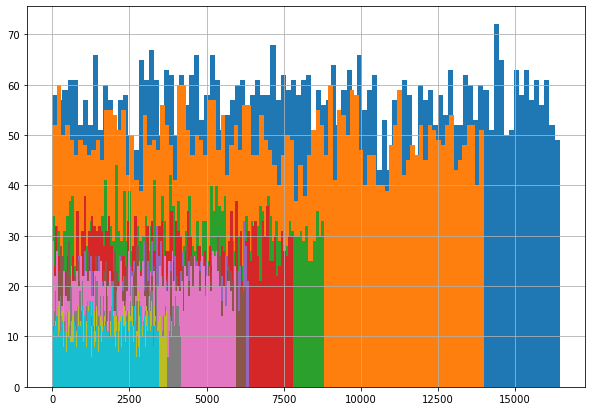

In [11]:
# посмотрим на топ 10 городов
for x in (df['City'].value_counts())[0:10].index:
    df['Ranking'][df['City'] == x].hist(bins=100)
plt.show()

<AxesSubplot:>

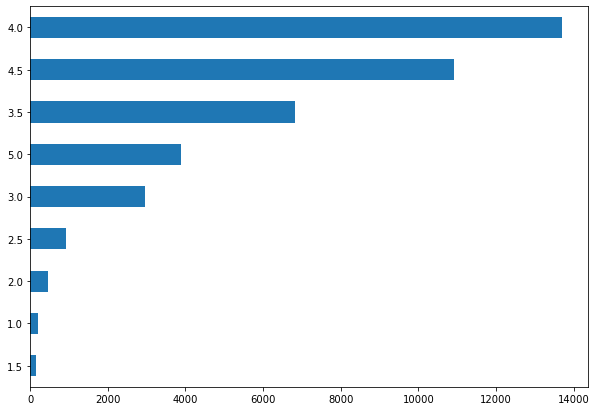

In [12]:
# Распределение целевой переменной.
df['Rating'].value_counts(ascending=True).plot(kind='barh')

In [13]:
# Количество городов в датасете.
df['City'].nunique()

31

In [14]:
# Создадим признак Rest_Counts - количество ресторанов в городе.
city_counts = dict(df['City'].value_counts())
df['Rest_Counts'] = df.City.map(city_counts)

In [15]:
# Из-за разнице в количестве ресторанов в городах разного размера - признак Ranking смещается. 
# Получим нормализованный признак - Ranking_Norm. 
df['Ranking_Norm'] = df['Ranking'] / df['Rest_Counts']

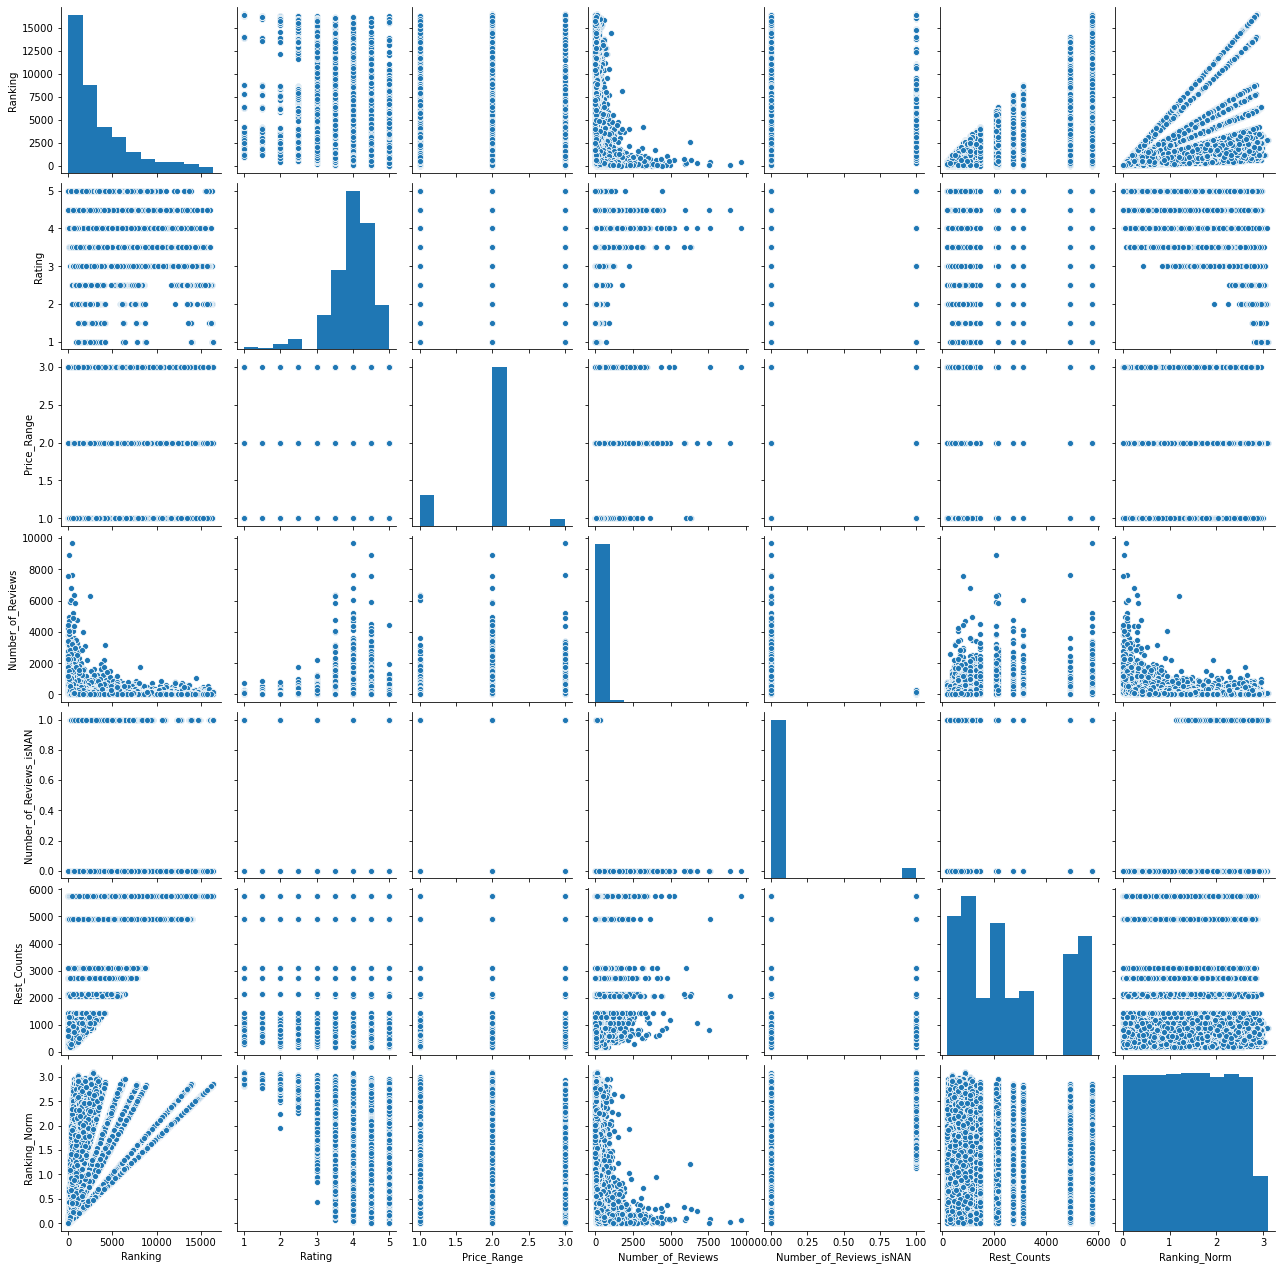

In [16]:
# Посмотрим гистограммы распределения признаков
sns.pairplot(df)

In [17]:
# Для каждого города в нашем Dataset собираем дополнительную информацию.
cities = df['City'].unique()
city_data = []

for city in cities:
    # Для каждого города в нашем Dataset определяем страну, количество жителей в городе, 
    # а также статус города (столица страны, региона, прочее).
    city_url = 'https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/World_Cities/FeatureServer/0/query?where=CITY_NAME%20%3D%20%27'+city+'%27&outFields=CITY_NAME,CNTRY_NAME,STATUS,POP&outSR=4326&f=json'
    city_json = json.load(urllib.request.urlopen(city_url))
    
    country = city_json['features'][0]['attributes']['CNTRY_NAME']
    if country == 'United Kingdom': 
        country = 'UNITED%20KINGDOM%20OF%20GREAT%20BRITAIN%20AND%20NORTHERN%20IRELAND'
    if country == 'Czech Republic': 
        country = 'Czechia'
    if country == 'Venezuela':   
        country = 'VENEZUELA%20(BOLIVARIAN%20REPUBLIC%20OF)'
    
    # Определяем, сколько туристов в год въезжает в страну, к которой относится город.
    country_url = 'https://services7.arcgis.com/gp50Ao2knMlOM89z/arcgis/rest/services/SYB115_2018/FeatureServer/0/query?where=refAreaDesc%20%3D%20%27'+country+'%27&outFields=refAreaDesc,value_latest_year&outSR=4326&f=json'
    country_json = json.load(urllib.request.urlopen(country_url))
    
    city_data.append([city, city_json['features'][0]['attributes']['CNTRY_NAME'], city_json['features'][0]['attributes']['POP'], city_json['features'][0]['attributes']['STATUS'], country_json['features'][0]['attributes']['value_latest_year']])

# Создаем DataFrame с дополнительной информацией по каждому городу.
df_cities = pd.DataFrame(city_data, columns=['City', 'Country', 'Population', 'Status', 'Arrivals'])


# Для каждого города в нашем Dataset, определяем GaWC level в GaWC city classification:
# Подробнее:
# https://en.wikipedia.org/wiki/Globalization_and_World_Cities_Research_Network
# При этом, сразу заменяем буквенные значения на баллы:
# alpha_plus_plus = 13 
# alpha_plus = 12 
# alpha = 11 
# alpha_minus = 10 
# beta_plus = 9 
# beta = 8 
# beta_minus = 7 
# gamma_plus = 6 
# gamma = 5 
# gamma_minus = 4 
# high_sufficiency = 3 
# sufficiency = 2 
# no_classified = 1
city_gawc = []

wiki = [
    ['https://en.wikipedia.org/w/index.php?title=Globalization_and_World_Cities_Research_Network&action=edit&section=4', 13], 
    ['https://en.wikipedia.org/w/index.php?title=Globalization_and_World_Cities_Research_Network&action=edit&section=5', 12], 
    ['https://en.wikipedia.org/w/index.php?title=Globalization_and_World_Cities_Research_Network&action=edit&section=6', 11], 
    ['https://en.wikipedia.org/w/index.php?title=Globalization_and_World_Cities_Research_Network&action=edit&section=7', 10], 
    ['https://en.wikipedia.org/w/index.php?title=Globalization_and_World_Cities_Research_Network&action=edit&section=9', 9], 
    ['https://en.wikipedia.org/w/index.php?title=Globalization_and_World_Cities_Research_Network&action=edit&section=10', 8], 
    ['https://en.wikipedia.org/w/index.php?title=Globalization_and_World_Cities_Research_Network&action=edit&section=11', 7], 
    ['https://en.wikipedia.org/w/index.php?title=Globalization_and_World_Cities_Research_Network&action=edit&section=13', 6], 
    ['https://en.wikipedia.org/w/index.php?title=Globalization_and_World_Cities_Research_Network&action=edit&section=14', 5], 
    ['https://en.wikipedia.org/w/index.php?title=Globalization_and_World_Cities_Research_Network&action=edit&section=15', 4], 
    ['https://en.wikipedia.org/w/index.php?title=Globalization_and_World_Cities_Research_Network&action=edit&section=17', 3], 
    ['https://en.wikipedia.org/w/index.php?title=Globalization_and_World_Cities_Research_Network&action=edit&section=18', 2], 
    ['https://en.wikipedia.org/w/index.php?title=Globalization_and_World_Cities_Research_Network&action=edit&section=19', 1]
]

for gawc in wiki:
    soup = BeautifulSoup(urllib.request.urlopen(gawc[0])).text
    city_pattern = re.compile('\[\[[\w\s]+')
    city_names = city_pattern.findall(soup)
    for city in city_names:
        city = city.replace('[', '')
        city = city.replace(' City', '')
        city = city.replace('ó', 'o')
        city = city.replace('ü', 'u')
        city_gawc.append([city.replace('[', ''), gawc[1]])
        
# Добавляем GaWC level в DataFrame с дополнительной информацией по каждому городу.
count = 0
for city in df_cities['City']:
    df_cities.loc[count, 'Gawc'] = 0
    for match in city_gawc:
        if city == match[0]:
            df_cities.loc[count, 'Gawc'] = match[1]
            break
    count += 1

In [18]:
# Добавляем в исходный DataFrame данные из DataFrame с дополнительной информацией по каждому городу.
rest = pd.merge(df, df_cities, how="left", sort=False)

In [19]:
# Проверяем количество строк в получившемся DataFrame
len(rest) == len(df)

True

In [20]:
rest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Restaurant_id            40000 non-null  object 
 1   City                     40000 non-null  object 
 2   Cuisine_Style            30717 non-null  object 
 3   Ranking                  40000 non-null  float64
 4   Rating                   40000 non-null  float64
 5   Price_Range              40000 non-null  int64  
 6   Number_of_Reviews        40000 non-null  float64
 7   Reviews                  40000 non-null  object 
 8   URL_TA                   40000 non-null  object 
 9   Number_of_Reviews_isNAN  40000 non-null  uint8  
 10  Rest_Counts              40000 non-null  int64  
 11  Ranking_Norm             40000 non-null  float64
 12  Country                  40000 non-null  object 
 13  Population               40000 non-null  int64  
 14  Status                

In [21]:
# Сгенерируем дополнительные признаки на основе дат, когда были оставлены отзывы:
# Review_days_ago - сколько дней назад был оставлен последний отзыв о ресторане.
# Review_days_delta - разница в количестве дней между последним и предпоследним отзывами о ресторане.

pattern1 = re.compile('\d\d[.]\d\d[.]\d\d\d\d')
pattern2 = re.compile('\d\d[/]\d\d[/]\d\d\d\d')
dt_now = datetime.now()
count = 0
for review in rest['Reviews']:
    if pattern2.search(review):
        string = pattern2.findall(review)
        if len(string) == 2:
            dt2 = datetime.strptime(string[0], '%m/%d/%Y')
            dt1 = datetime.strptime(string[1], '%m/%d/%Y')
            if dt2 > dt1:
                dt_delta = dt2 - dt1
                dt_now_delta = dt_now - dt2
            else:
                dt_delta = dt1 - dt2
                dt_now_delta = dt_now - dt1
        rest.loc[count, 'Review_days_ago'] = dt_now_delta.days
        rest.loc[count, 'Review_days_delta'] = dt_delta.days
        
    elif pattern1.search(review):
        string = pattern1.findall(review)
        if len(string) == 2:
            dt2 = datetime.strptime(string[0], '%d.%m.%Y')
            dt1 = datetime.strptime(string[1], '%d.%m.%Y')
            if dt2 > dt1:
                dt_delta = dt2 - dt1
                dt_now_delta = dt_now - dt2
            else:
                dt_delta = dt1 - dt2
                dt_now_delta = dt_now - dt1
        rest.loc[count, 'Review_days_ago'] = dt_now_delta.days
        rest.loc[count, 'Review_days_delta'] = dt_delta.days
    
    else:
        rest.loc[count, 'Review_days_ago'] = np.NaN
        rest.loc[count, 'Review_days_delta'] = np.NaN
    
    count += 1

In [22]:
# Заполняем пустые значения новых признаков средним, с группировкой по городам.
reviews_days_ago_mean = round(rest.groupby('City')['Review_days_ago'].mean())
rest['Review_days_ago'] = rest['Review_days_ago'].fillna(rest['City'].map(reviews_days_ago_mean))

reviews_days_delta_mean = round(rest.groupby('City')['Review_days_delta'].mean())
rest['Review_days_delta'] = rest['Review_days_delta'].fillna(rest['City'].map(reviews_days_delta_mean))

In [23]:
# Изучим получившийся DataFrame
rest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Restaurant_id            40000 non-null  object 
 1   City                     40000 non-null  object 
 2   Cuisine_Style            30717 non-null  object 
 3   Ranking                  40000 non-null  float64
 4   Rating                   40000 non-null  float64
 5   Price_Range              40000 non-null  int64  
 6   Number_of_Reviews        40000 non-null  float64
 7   Reviews                  40000 non-null  object 
 8   URL_TA                   40000 non-null  object 
 9   Number_of_Reviews_isNAN  40000 non-null  uint8  
 10  Rest_Counts              40000 non-null  int64  
 11  Ranking_Norm             40000 non-null  float64
 12  Country                  40000 non-null  object 
 13  Population               40000 non-null  int64  
 14  Status                

<AxesSubplot:>

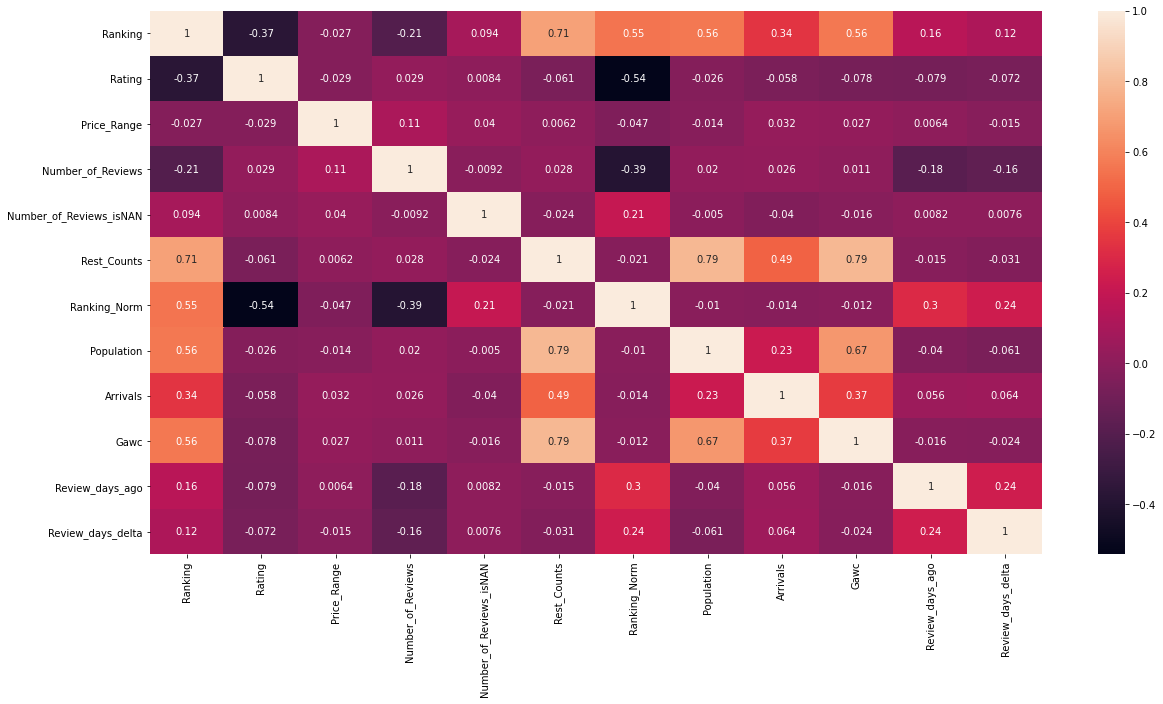

In [24]:
# Изучаем матрицу корреляций
plt.rcParams['figure.figsize'] = (20,10)
sns.heatmap(round(rest,2).corr(),annot=True)

In [25]:
# Для всех ресторанов, у которых не указан стиль кухни, заполним пропущенное значение таким - International
rest['Cuisine_Style'] = rest['Cuisine_Style'].fillna('[\'International\']')

# Сгенерируем дополнительный признак на основе стилей кухонь в каждом из ресторанов:
# Cuisine_count - количество стилей кухни в ресторане.
pattern = re.compile('[a-zA-Z0-9_][a-zA-Z0-9_& ]+')
count = 0
for recipe in rest['Cuisine_Style']:
    string = pattern.findall(recipe)
    count_in = 0
    for ing in string:
        count_in += 1
    rest.loc[count, 'Cuisine_count'] = count_in
    count += 1

In [26]:
# Для оптимизации модели, нормализуем признаки с большИми значениями:
# Population, Arrivals
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#rest[['Population', 'Arrivals']] = scaler.fit_transform(rest[['Population', 'Arrivals']])

# Изучим получившийся DataFrame
#rest.sample(5)

In [27]:
# Создаём dummy variables для значений кухонь.

# Создаём множество для хранения уникальных значений кухонь.
ingredients = set()  
pattern = re.compile('[a-zA-Z0-9_][a-zA-Z0-9_& ]+')

for recipe in rest['Cuisine_Style']:
    string = pattern.findall(recipe)
    for ing in string:
        ingredients.add(ing)

# Создаем признаки для каждого из названий кухни и для всех строк устанавливаем значение = 0
for col in ingredients:
    rest[col] = 0

# Заполняем для каждого ресторана созданные dummy variables, устанавливая значение = 1, если такая кухня в ресторане есть.
count = 0
for recipe in rest['Cuisine_Style']:
    string = pattern.findall(recipe)
    for ing in string:
        rest.loc[count, ing] = 1
    count += 1 

In [28]:
# Создаём dummy variables для городов, стран и статусов города.
rest = pd.get_dummies(rest, columns=['City', 'Country', 'Status',])

In [29]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = rest.drop(['Restaurant_id', 'Ranking', 'Rating', 'Cuisine_Style', 'Reviews', 'URL_TA'], axis = 1)
y = rest['Rating']

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [31]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [32]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20596749999999997


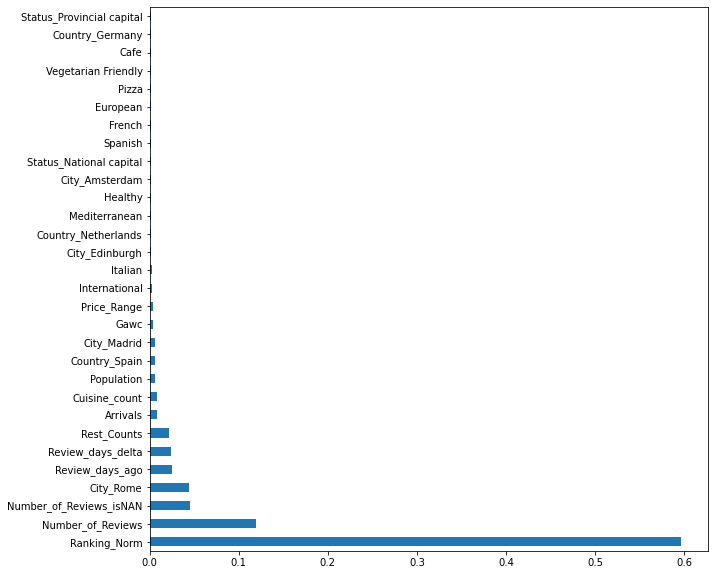

In [33]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh');